# Import Libraries

In [133]:
from kafka import KafkaConsumer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from json import dumps
import numpy as np
import pickle
from sklearn.metrics import classification_report,accuracy_score,f1_score

# Required Functions

In [134]:
col_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]

In [135]:
def get_first_1000_as_dataframe(consumer):
    data = []
    count = 0
    for m in consumer:
        if count < 1000:
            row_string=eval(m.value.decode("UTF-8"))
            row_string = row_string.strip()
            row= row_string.split(",")
            data.append(row)
            count += 1
        else:
            break

    df = pd.DataFrame(data, columns=col_names)
    df.drop(columns=["timestamp","longest_word", "sld"],inplace=True)

    return df.astype(float),df

In [136]:
def get_1000_rec(itr):
    list_of_1000_rec=[]
    i=0
    for c in consumer:
        if i <1000:
            list_of_1000_rec.append(c.value)
            i=i+1
        else:
            break
    print(f"Window {itr}")
    return list_of_1000_rec

In [137]:
def adjust_data( data):
    dataframe=pd.DataFrame()
    list_of_rows=[]
    for item in data:
        row_string=eval(item.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        list_of_rows.append(row)
    dataframe=pd.DataFrame(list_of_rows)
    dataframe.columns=col_names
    return dataframe

In [138]:
def cleaning_the_data(data):
    data_copy = data.copy()
    data_copy.dropna(inplace=True)
    le = LabelEncoder()
    data_copy["longest_word"] = le.fit_transform(data_copy["longest_word"])
    data_copy["sld"] = le.fit_transform(data_copy["sld"])
    data_copy['sld']=data_copy['sld'] .astype('int')
    data_copy=data_copy.drop_duplicates()
    data_copy.drop('timestamp', inplace=True, axis=1)
    return data_copy.astype('float')

In [139]:
def retrain(data):

    pipe = Pipeline(steps=[('scaler ',MinMaxScaler()),("MI with DT",SelectKBest(score_func=mutual_info_classif, k=7)), ("DecisionTreeClassifier", DecisionTreeClassifier())])
    X_scaled =data.drop(labels = ["Target Attack"], axis=1)
    y=data["Target Attack"]
    pipe.fit(X_scaled,y)
    return pipe

# Read Data

In [140]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False)

for m in consumer:
    m.value
    break

In [141]:
_,df=get_first_1000_as_dataframe(consumer)

In [142]:
df

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,Target Attack
0,13,0,0,12,0,2.781301471,1,2,10,6,11,0,0
1,25,8,0,10,9,2.786215626,6,6,7,3.333333333,12,1,0
2,8,0,0,6,0,2.154135417,2,2,5,3.5,6,0,0
3,20,3,0,18,0,2.905639062,2,3,12,6,16,1,0
4,27,10,0,10,11,2.767194749,6,6,7,3.666666667,14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,13,0,0,10,2,2.989735285,1,2,9,6,10,0,0
996,24,7,0,10,8,2.054028744,6,6,7,3.166666667,11,1,0
997,11,0,0,10,0,2.817711112,1,2,8,5,9,0,0
998,12,0,0,11,0,2.514246535,1,2,9,5.5,10,0,0


# Model

In [143]:
pickle.load(open('ch2_dt_model.pkl', 'rb'))

C:\Users\HP\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SelectKBest from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your o

Pipeline(steps=[('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function chi2 at 0x000001E85CD47C10>)),
                ('classifier',
                 DecisionTreeClassifier(min_samples_leaf=2, random_state=42))])

In [144]:
static_model = Dynamic_model= pickle.load(open('ch2_dt_model.pkl', 'rb'))

In [145]:
training_data=cleaning_the_data(adjust_data(get_1000_rec(0)))
list_of_f1_Dynmaic_model=[]
list_of_f1_static_model=[]
for itr in range(1,200):
    r_dataset = get_1000_rec(itr)
    p_dataset =  adjust_data(r_dataset)
    new_dataset =  cleaning_the_data(p_dataset)
    X =new_dataset.drop(labels = ["Target Attack"], axis=1)
    y=new_dataset["Target Attack"]

    Dy_pred=Dynamic_model.predict(X)
    D_f1=f1_score(y,Dy_pred)
    print(f"The F1 Score of Dynamic Model without retrain = {D_f1*100}%")
    if D_f1 < 0.85 :

        print(" trained model on the new data")
        Dynamic_model=retrain(training_data)
        Dy_pred=Dynamic_model.predict(X)
        D_f1=f1_score(y,Dy_pred)
        print(f"The f1 of Dynamic Model after retrain = {D_f1*100}%")
    training_data=pd.concat([training_data,new_dataset])
    Sy_pred=static_model.predict(X)
    S_f1=f1_score(y,Sy_pred)
    print(f"The F1 of Static Model = {S_f1*100}%")
    list_of_f1_Dynmaic_model.append(D_f1)
    list_of_f1_static_model.append(S_f1)
    print(f"{'*'*10}")


Window 0
Window 1
The F1 Score of Dynamic Model without retrain = 82.94209702660407%
 trained model on the new data
The f1 of Dynamic Model after retrain = 15.181518151815181%
The F1 of Static Model = 82.94209702660407%
**********
Window 2
The F1 Score of Dynamic Model without retrain = 12.924071082390956%
 trained model on the new data
The f1 of Dynamic Model after retrain = 55.745164960182024%
The F1 of Static Model = 85.2080123266564%
**********
Window 3
The F1 Score of Dynamic Model without retrain = 82.79835390946502%
 trained model on the new data
The f1 of Dynamic Model after retrain = 83.26530612244898%
The F1 of Static Model = 82.57328990228014%
**********
Window 4
The F1 Score of Dynamic Model without retrain = 84.84848484848484%
 trained model on the new data
The f1 of Dynamic Model after retrain = 84.399375975039%
The F1 of Static Model = 84.5565749235474%
**********
Window 5
The F1 Score of Dynamic Model without retrain = 84.05341712490181%
 trained model on the new data
T

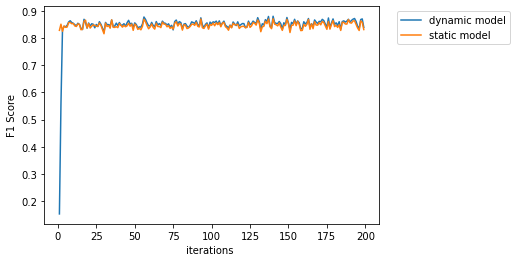

In [146]:
import matplotlib.pyplot as plt
plt.plot(range(1, 200), list_of_f1_Dynmaic_model, label=f'dynamic model')
plt.plot(range(1, 200),list_of_f1_static_model, label=f'static model')
plt.xlabel('iterations ')
plt.ylabel("F1 Score")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")